<a href="https://colab.research.google.com/github/mulherinstephen/avalanche/blob/main/avalanche.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Avalanches Danger Rating**

### **Project Description**
Avalanche centers issue a daily avalanche danger rating. The rating can be low, moderate, considerable, high, or extreme. Meteorological events are by far the largest contributer to avalanche conditions. This project aims to predict these danger ratings.
### **Dataset**
Using data collected from MesoWest, I import measurements from the Raymer weather station within the Jackson Hole Mountain Resort ski area. This station has the most consistent data. See below for a list of measurements and units.

Wind Speed: m/s

Wind Direction: degree or cardinal

Temp/Dew Point: celsius

Snow Depth/Interval: mm

Relative Humidity: %

## **Import Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Avalanche'

/content/drive/MyDrive/Avalanche


In [3]:
!ls

JHB.2021-01-09.csv    JHR.2021-01-09.csv  label_data.csv
JHMWY.2021-01-09.csv  JHS.2021-01-09.csv


In [4]:
import pandas as pd
import numpy as np

r_col=['station','date_time','air_temp','r_humidity','wind_speed','wind_deg','wind_gust','snow_depth','snow_interval','dew_point','wind_cardinal']
df_JHR=pd.read_csv('JHR.2021-01-09.csv',names=r_col,skiprows=12)

df_label=pd.read_csv('label_data.csv')

### **label_data.csv**

label_data.csv is imported above as a file I saved to my local drive after crawling the Bridger Teton Avalanche Center's website for historical archives of avalanche danger all the way back to 1999-11-23. This runtime took around 10 minutes so I took this strategy in order to avoid running this code block everytime. The code for crawling jhavalanche.org (Bridger Teton Avalanche Center) is commented out in the code block below. 

From 1999-2012 the danger rating can be easily scraped. From 2012-2020 the danger ratings are in a preloaded gif. Since there are 5**6 possible danger rating gif's, this presents a challenge. Luckily, I discovered a 'printable version' of each archive with the date in the url and the danger rating in a table format! This makes it easily scrapable except for one unfortunate problem, the rating are transcribed incorretly from the 'regular version' to the 'printable version.' If the danger is 2 in the morning but 3 in the afternoon, the 'printable version' shows 3 for both am and pm. This is fine since the danger always trends more dangerous intra-day, never less dangerous. The model will be forced to be more conservative (predict higher danger on average) which is desirable for this problem.

In [5]:
# import requests
# from bs4 import BeautifulSoup
# import re

# def extract_danger(url):
#   page=requests.get(url)
#   soup=BeautifulSoup(page.content,'html.parser')
#   if len(soup.find_all("table", { "class" : "responsive-card-table unstriped" }))>1:      #this should handle archive being found
#     danger_table=soup.find_all("table", { "class" : "responsive-card-table unstriped" })[1].find('tbody')
#     high_elev_row=danger_table.find_all('tr')[0]
#     cell=high_elev_row.find_all('td')
#     am_danger=cell[1].text
#     pm_danger=cell[2].text
#     am_danger_str=re.findall('\w+', am_danger)[-1]      #if rating is mixed like low/moderate...choose more dangerous label
#     pm_danger_str=re.findall('\w+', pm_danger)[-1]
#     danger_str=['LOW','MODERATE','CONSIDERABLE','HIGH','EXTREME','AVAILABLE','RATING']    #last two are 'not available' or 'no rating'
#     am_danger_ord=danger_str.index(am_danger_str)+1     #code the rating on a scale from 1-5
#     pm_danger_ord=danger_str.index(pm_danger_str)+1
#     return am_danger_ord,pm_danger_ord
#   else:
#     return 'archive not found'


# unique_dates=df_JHR_proc.index.map(lambda t: t.date()).unique()
# target_labels={}
# base_url='http://jhavalanche.org/viewTeton?data_date={}-{}-{}&template=teton_print.tpl.php'
# for u in unique_dates:
#   ratings=extract_danger(base_url.format(u.year,u.month,u.day))
#   target_labels[u]=ratings

# from google.colab import files
# label_df.T.to_csv('label_data.csv')
# files.download("label_data.csv")

## **Data Cleaning**

In [6]:
#Convert to time series
df_JHR.index=pd.to_datetime(df_JHR['date_time'])
df_JHR.sort_index(inplace=True)
df_JHR.drop(['date_time','station'],inplace=True,axis=1)

#The values ['archive not found',6, or 7] need to be replaced with null. Only keep the pm danger rating. Convert to time series.
df_label.replace('archive not found',np.nan,inplace=True)
label_cols=['date_time','am','danger_rating']
df_label.columns=label_cols
df_label['danger_rating']=df_label['danger_rating'].astype(float)
df_label.index=pd.to_datetime(df_label['date_time'])
df_label.drop(['date_time','am'],inplace=True,axis=1)
df_label=df_label.replace(7,np.nan).replace(6,np.nan)

#Make indices compatible and join the two DataFrames. Interpolate danger rating for intra-day indices.
df_label.index=df_label.index.tz_localize(tz='UTC')
df_JHR=df_JHR.join(df_label)
df_JHR['danger_rating'].ffill(inplace=True)

## **Exploratory Data Analysis**

In [7]:
df_JHR.head(10)

,air_temp,r_humidity,wind_speed,wind_deg,wind_gust,snow_depth,snow_interval,dew_point,wind_cardinal,danger_rating
date_time,,,,,,,,,,
1999-11-23 00:00:00+00:00,-12.78,76.0,9.83,330.0,13.84,5130.8,NaN,-16.17,NNW,NaN
1999-11-23 00:15:00+00:00,-13.33,75.0,9.83,328.0,12.96,5130.8,NaN,-16.86,NNW,NaN
1999-11-23 00:30:00+00:00,-13.33,74.0,9.41,330.0,12.50,5130.8,NaN,-17.02,NNW,NaN
1999-11-23 00:45:00+00:00,-13.33,75.0,7.15,326.0,10.29,5130.8,NaN,-16.86,NW,NaN
1999-11-23 01:00:00+00:00,-13.33,77.0,7.15,330.0,10.29,5130.8,NaN,-16.54,NNW,NaN
1999-11-23 01:15:00+00:00,-13.33,76.0,6.69,328.0,10.75,5130.8,NaN,-16.70,NNW,NaN
1999-11-23 01:30:00+00:00,-13.33,76.0,5.81,329.0,8.95,5130.8,NaN,-16.70,NNW,NaN
1999-11-23 01:45:00+00:00,-13.33,77.0,4.48,332.0,7.15,5130.8,NaN,-16.54,NNW,NaN
1999-11-23 02:00:00+00:00,-13.33,76.0,2.68,323.0,6.28,5130.8,NaN,-16.70,NW,NaN


In [8]:
df_JHR.describe()

,air_temp,r_humidity,wind_speed,wind_deg,wind_gust,snow_depth,snow_interval,dew_point,danger_rating
count,469367.000000,469106.000000,381892.000000,363395.000000,381855.000000,488390.000000,461962.000000,467965.000000,508348.000000
mean,-2.582219,68.754493,3.919146,249.332820,7.761635,1988.665745,164.591903,-8.754176,2.182454
std,8.748211,23.594326,3.210716,81.156307,5.464153,1528.367175,374.676323,6.300698,0.787946
min,-52.780000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-64.000000,1.000000
25%,-8.890000,49.000000,2.230000,194.000000,4.470000,838.200000,0.000000,-12.870000,2.000000
50%,-3.890000,76.000000,3.580000,283.000000,7.150000,1828.800000,0.000000,-8.500000,2.000000
75%,2.220000,89.000000,5.370000,307.000000,10.280000,2565.400000,127.000000,-4.500000,3.000000
max,53.890000,100.000000,89.850000,360.000000,98.790000,12623.800000,3810.000000,15.560000,5.000000


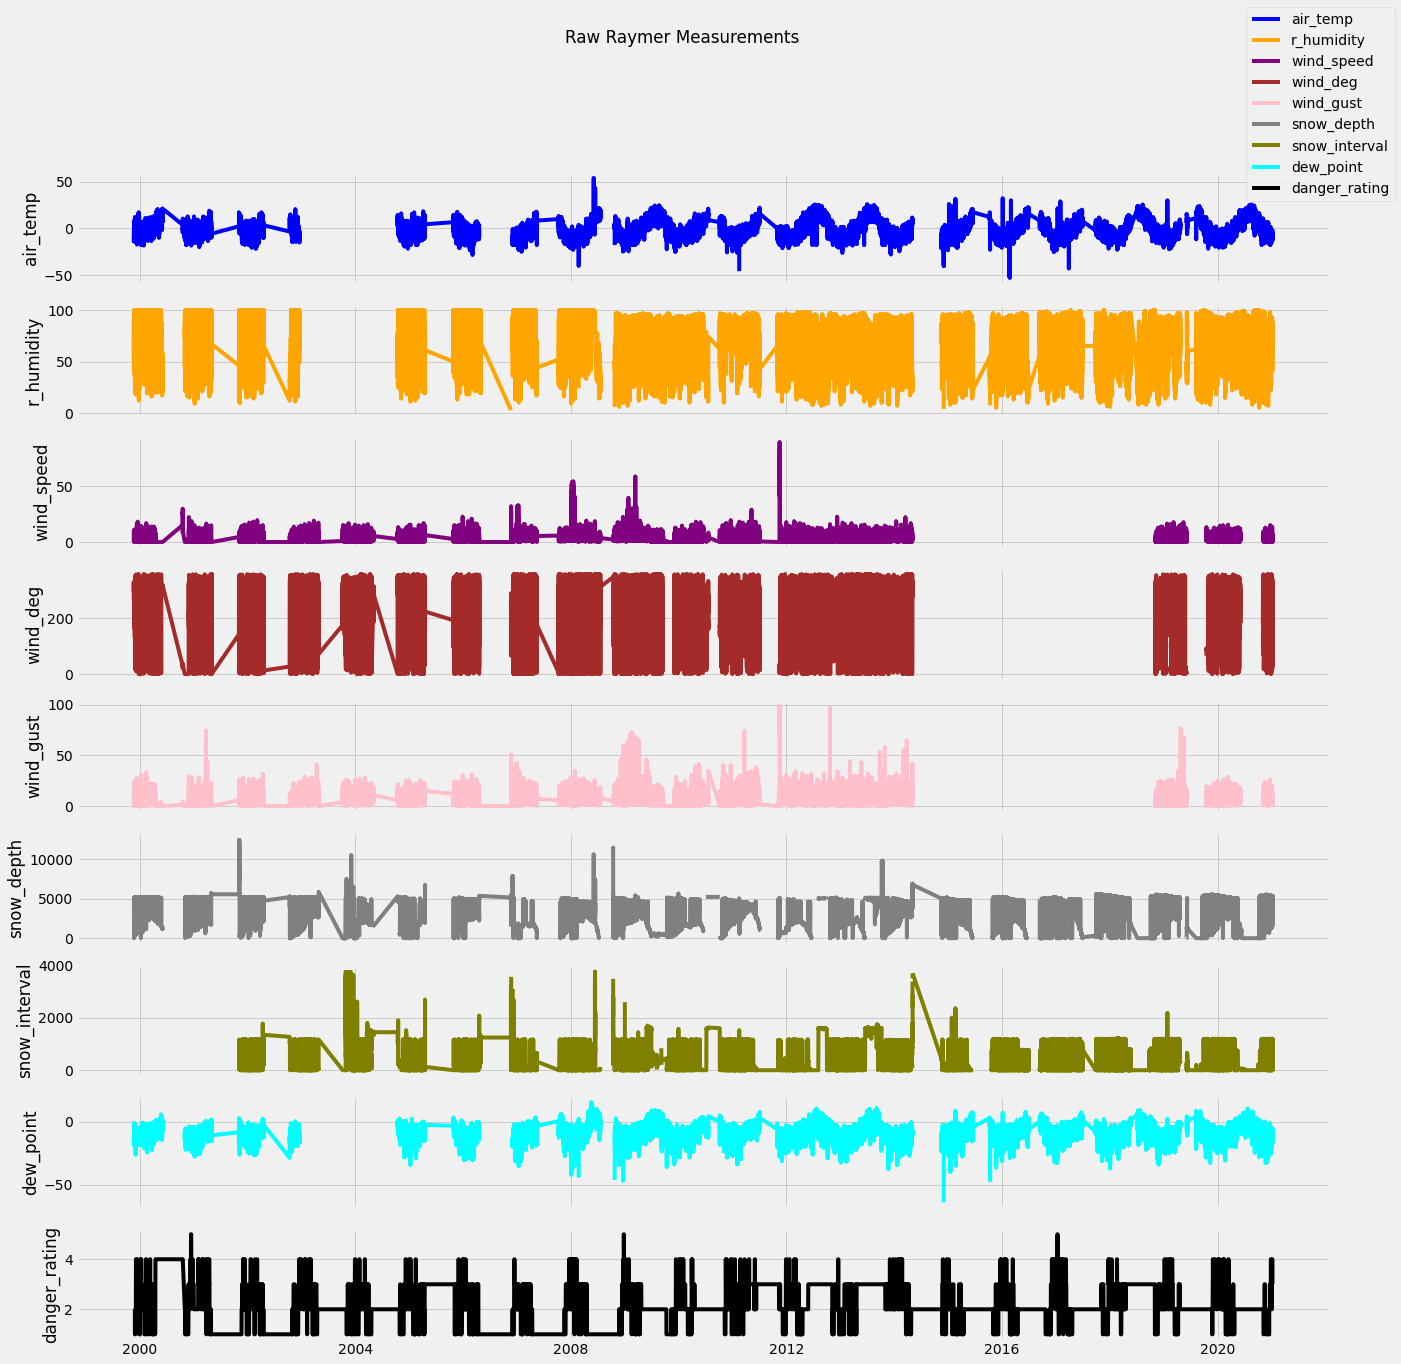

In [9]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

def my_plot(df,title):

  style.use('fivethirtyeight')

  #Only plot float columns
  cols=[c for c in df if df[c].dtype==float]

  n=len(cols)
  color=['blue','orange','purple','brown','pink','gray','olive','cyan','black']

  fig,axs = plt.subplots(n,1,sharex=True,figsize=(20,20))

  for i,c in enumerate(cols):
    axs[i].plot(df[c],label=c,c=color[i])
    axs[i].set_ylabel(c)

  fig.suptitle(title)
  fig.legend()

my_plot(df_JHR,'Raw Raymer Measurements')

## **Feature Engineering**
Use linear interpolation, ffill, and bfill to fill in missing values. Normalize data using MinMaxScaler from scikit-learn. Finally, convert wind_cardinal to dummy variables. 

In [10]:
from sklearn.preprocessing import MinMaxScaler

df_JHR=df_JHR.interpolate().bfill().ffill()
dummy_df=pd.get_dummies(df_JHR['wind_cardinal'],drop_first=True,dtype=float)
df_JHR=df_JHR.join(dummy_df)

In [11]:
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(index=df_JHR.index,data=scaler.fit_transform(df_JHR.loc[:,:'dew_point']))
df_scaled.columns='scaled_'+df_JHR.columns[:8]

In [12]:
df_processed=df_scaled.join(df_JHR.loc[:,'wind_cardinal':])
df_processed.drop('wind_cardinal',axis=1,inplace=True)

In [13]:
#sanity check
df_processed.describe()

,scaled_air_temp,scaled_r_humidity,scaled_wind_speed,scaled_wind_deg,scaled_wind_gust,scaled_snow_depth,scaled_snow_interval,scaled_dew_point,danger_rating,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000
mean,0.467394,0.662868,0.041118,0.619463,0.071307,0.156189,0.042371,0.686424,2.182282,0.024496,0.007228,0.228496,0.010547,0.012765,0.042490,0.177116,0.096959,0.014941,0.038033,0.034857,0.028941,0.084626,0.154064,0.036537
std,0.081965,0.244212,0.032620,0.258185,0.051494,0.122186,0.096424,0.087084,0.787624,0.154585,0.084710,0.419864,0.102157,0.112258,0.201704,0.381768,0.295902,0.121317,0.191277,0.183418,0.167642,0.278325,0.361010,0.187621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.406300,0.453608,0.020033,0.466667,0.040692,0.062374,0.000000,0.632604,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.453173,0.721649,0.037737,0.707039,0.067187,0.142857,0.000000,0.692685,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.515609,0.876289,0.054758,0.833333,0.090495,0.203219,0.027905,0.745726,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
#Create a 24-hr and 48-hr lag features
lag_24hr=df_processed['danger_rating'].shift(4*24).rename('lag_24hr')
lag_48hr=df_processed['danger_rating'].shift(4*48).rename('lag_48hr')

df_processed=pd.concat([df_processed,lag_24hr,lag_48hr],axis=1)
df_processed=df_processed.iloc[4*48:,:]

## **Multicollinearity**

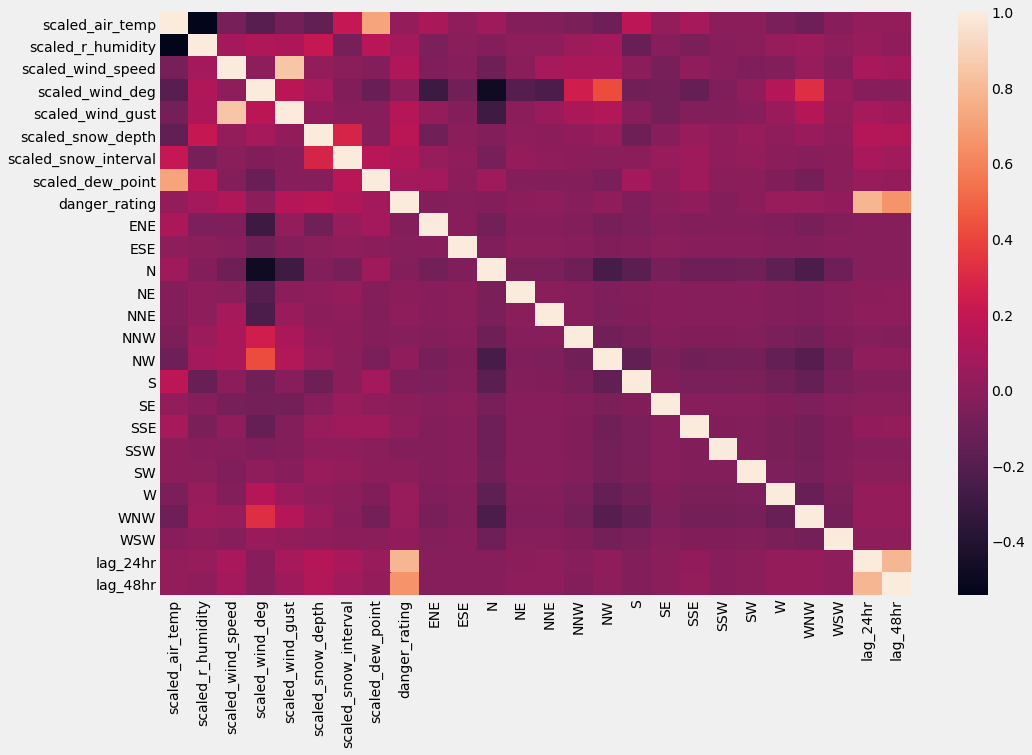

In [15]:
import seaborn as sns
corr=df_processed.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr)



*   wind_deg can be inferred from all wind dummy variables. Drop wind_deg.
*   air_temp, r_humidity, and dew_pint are all closely correlated. Drop r_humidity and dew_point.

*   snow_interval and snow_depth are collinear. Drop snow_interval. It is the measurement of snow on an interval board which is a bit inconsistent and susceptible to human error. 
*   wind_speed and wind_gust are highly correlated. Drop wind_gust. Sustained wind gusts are the primary factor in transporting snow to create wind slab avalanches.








In [16]:
df_processed.drop(['scaled_wind_deg','scaled_r_humidity','scaled_dew_point','scaled_snow_interval','scaled_wind_gust'],axis=1,inplace=True)

## **Imbalanced Classification**
There are very few extreme danger ratings over the past 20 years. This will cause the model to poorly predict these ratings. Check all danger rating classes for imbalances and perform over-sampling.

In [17]:
df_processed['danger_rating'].value_counts(normalize=True)

2.0    0.494630
3.0    0.271147
1.0    0.186000
4.0    0.047467
5.0    0.000756
Name: danger_rating, dtype: float64

This is certainly imbalanced. Over-sampling for this problem is messy. Instead I will use cost-sensative learning when I build the models.

# **Models**
I will use Logistic Regression and Random Forest classifiers. Multi-layer Perceptron classifiers do not allow for class_weight tuning to deal with class imbalance problems. This will result in the majority class accuracy problem where good results come from frequently predicting one of the majority classes. Once I fit a base model for each classifier, I will check for the best subset of features.

## **Logistic Regression**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score,confusion_matrix

def my_logreg(X,y):

  tscv=TimeSeriesSplit()

  for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced',multi_class='ovr')
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)

    print('\nAccuracy Score:')
    print(accuracy_score(y_test,pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test,pred))


X=df_processed.drop('danger_rating',axis=1)
y=df_processed['danger_rating']
my_logreg(X,y)


Accuracy Score:
0.662626881859873

Confusion Matrix:
[[28279  3136   693   155     0]
 [ 6964 19515  5444   980    78]
 [ 1430  4598  7561  2411   494]
 [    0   454  1596   851   184]
 [    0     0     0     0     0]]

Accuracy Score:
0.558327340461903

Confusion Matrix:
[[10072  2089   226     0     0]
 [15140 26364  6147  1218    94]
 [  492  3417 10192  6057   346]
 [  139   486  1440   731    77]
 [    0    19    73     4     0]]

Accuracy Score:
0.6316682975136461

Confusion Matrix:
[[ 6124  2026   207     5     0]
 [ 4858 21119  4173   255   463]
 [  429  5664 26154 10458   709]
 [  192   360  1250   183   194]
 [    0     0     0     0     0]]

Accuracy Score:
0.7077915188097568

Confusion Matrix:
[[11911  2917    22     0     2]
 [ 4377 43169  4013  1053   851]
 [  432  2271  4526  4401  2460]
 [   96   287  1278   341   319]
 [    0     0     6     1    90]]

Accuracy Score:
0.8336771866121218

Confusion Matrix:
[[ 6251  1491   259    40     0]
 [ 2741 43006  3516   417   23

## **Random Forrest Classifier**

In [19]:
from sklearn.ensemble import RandomForestClassifier

def my_rfc(X,y):

  tscv=TimeSeriesSplit()

  for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    
    print('\nAccuracy Score:')
    print(accuracy_score(y_test,pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test,pred))


X=df_processed.drop('danger_rating',axis=1)
y=df_processed['danger_rating']
my_rfc(X,y)


Accuracy Score:
0.6515803496693114

Confusion Matrix:
[[28602  2989   275   339    58]
 [ 5961 21175  3159  1165  1521]
 [ 1819  4062  4754  2654  3205]
 [   96   575  1195   738   481]
 [    0     0     0     0     0]]

Accuracy Score:
0.6601275597420511

Confusion Matrix:
[[10084  2206     0    97     0]
 [ 2208 42754  1235  1476  1290]
 [  305  5861  2355  8805  3178]
 [  101   948   358   732   734]
 [    0     0    27     0    69]]

Accuracy Score:
0.6677669971587895

Confusion Matrix:
[[ 5866  2277   159    27    33]
 [ 2153 24504   503   489  3219]
 [  341  4538 25986  6359  6190]
 [   55   862   231   286   745]
 [    0     0     0     0     0]]

Accuracy Score:
0.7319005458425192

Confusion Matrix:
[[11411  3441     0     0     0]
 [ 2962 47890  1128     0  1483]
 [  384  4342  2727     2  6635]
 [   96   480   943     0   802]
 [    0     0    43     0    54]]

Accuracy Score:
0.778821781828042

Confusion Matrix:
[[ 6546  1399    96     0     0]
 [ 3773 44032   710   134  12

## **Feature Selection**
The two models predicted both the majority classes (2 and 3) and minority classes (1, 4, and 5) equally well. Lets look at different subsets of features to see if one model starts to perform better.

In [20]:
X=df_processed[['lag_24hr']]
y=df_processed['danger_rating']
my_logreg(X,y)


Accuracy Score:
0.7250863562948728

Confusion Matrix:
[[27752  3839   672     0]
 [ 3461 23670  5850     0]
 [  954  4897  8820  1823]
 [    0   671  1152  1262]]

Accuracy Score:
0.7985687844098889

Confusion Matrix:
[[ 9987  2400     0     0     0]
 [ 2112 42348  4407    96     0]
 [  288  3511 14617  2088     0]
 [   96   608  1384   785     0]
 [    0     0    96     0     0]]

Accuracy Score:
0.817655588696462

Confusion Matrix:
[[ 5866  2304   192     0     0]
 [ 2153 24779  3744     0   192]
 [  288  3168 38711     0  1247]
 [   55   617   767     0   740]
 [    0     0     0     0     0]]

Accuracy Score:
0.8258609103662922

Confusion Matrix:
[[11411  3441     0     0     0]
 [ 2961 47430  3072     0     0]
 [  384  2400 11210     0    96]
 [   96   288  1937     0     0]
 [    0     0    96     0     1]]

Accuracy Score:
0.8824847034412836

Confusion Matrix:
[[ 6226  1719    96     0]
 [ 1719 46086  2112     0]
 [   96  1728 22543     0]
 [    0   384  2114     0]]


In [21]:
my_rfc(X,y)


Accuracy Score:
0.6346863468634686

Confusion Matrix:
[[27752  3839     0   672]
 [ 3461 23670     0  5850]
 [  954  4897     0 10643]
 [    0   671     0  2414]]

Accuracy Score:
0.6414298008794784

Confusion Matrix:
[[ 9987  2400     0     0     0]
 [ 2112 42348     0  4503     0]
 [  288  3511     0 16705     0]
 [   96   608     0  2073    96]
 [    0     0     0    96     0]]

Accuracy Score:
0.3612817278332528

Confusion Matrix:
[[ 5866  2304     0     0   192]
 [ 2153 24779     0     0  3936]
 [  288  3168     0     0 39958]
 [   55   617     0     0  1507]
 [    0     0     0     0     0]]

Accuracy Score:
0.6999045070322908

Confusion Matrix:
[[11411  3441     0     0     0]
 [ 2961 47430     0    96  2976]
 [  384  2400     0  1795  9511]
 [   96   288     0   430  1507]
 [    0     0     0     0    97]]

Accuracy Score:
0.6303243224125532

Confusion Matrix:
[[ 6226  1719     0     0    96]
 [ 1719 46086     0     0  2112]
 [   96  1728     0  1344 21199]
 [    0   384     0

In [22]:
X=df_processed[['scaled_air_temp','scaled_wind_speed','scaled_snow_depth','lag_24hr','lag_48hr']]
y=df_processed['danger_rating']
my_logreg(X,y)


Accuracy Score:
0.6558480600780449

Confusion Matrix:
[[28301  3150   560   252     0]
 [ 6897 19615  5152   969   348]
 [ 1372  4283  6973  2652  1214]
 [    3   589  1471   742   280]
 [    0     0     0     0     0]]

Accuracy Score:
0.541999221909152

Confusion Matrix:
[[10024  2184   179     0     0]
 [15616 26288  5159  1423   477]
 [  357  2927  8923  7373   924]
 [   96   512  1239   739   287]
 [    0     0    96     0     0]]

Accuracy Score:
0.6141023071572569

Confusion Matrix:
[[ 5866  2294   199     0     3]
 [ 2155 24013  3795   153   752]
 [  288  5077 22047 14628  1374]
 [   57   604   979   164   375]
 [    0     0     0     0     0]]

Accuracy Score:
0.7574950190396472

Confusion Matrix:
[[11630  3202    18     0     2]
 [ 3624 44763  4233   302   541]
 [  432  2278  7832  2004  1544]
 [   96   288  1690    27   220]
 [    0     0    95     1     1]]

Accuracy Score:
0.8503236150572369

Confusion Matrix:
[[ 6280  1638   123     0     0]
 [ 1857 45356  2011   222   4

In [23]:
my_rfc(X,y)


Accuracy Score:
0.6381523879136555

Confusion Matrix:
[[28425  3165   192   353   128]
 [ 5400 21726  2005  1302  2548]
 [ 1731  4120  3365  2809  4469]
 [   96   575   957   614   843]
 [    0     0     0     0     0]]

Accuracy Score:
0.7764639307734931

Confusion Matrix:
[[ 9987  2400     0     0     0]
 [ 2112 43718  2670   461     2]
 [  288  6020 11974  2222     0]
 [   96   984  1514   183    96]
 [    0     0    96     0     0]]

Accuracy Score:
0.3649010292019853

Confusion Matrix:
[[ 5866  2274     0   186    36]
 [ 2153 24554     0  1123  3038]
 [  341  4857     0 33180  5036]
 [   55   877     0   532   715]
 [    0     0     0     0     0]]

Accuracy Score:
0.7156077950555864

Confusion Matrix:
[[11411  3441     0     0     0]
 [ 2961 46401  2626     1  1474]
 [  384  4259  2824    13  6610]
 [   96   480   943    10   792]
 [    0     0    43     0    54]]

Accuracy Score:
0.79621093335534

Confusion Matrix:
[[ 6591  1344    96     0    10]
 [ 2871 45122   668    79  117

## **Conclusion**
It looks like Logistic Regression performed the best when the only feature used was lag_24hr. Consistently accurate around 80%. Potential opportunities to to improve accuracy:

*   Improve resampling with time series data in order to fix the imbalanced classification problem
*   Look into LSTM Models using Keras. This model could be a good fit for my problem
*   There could be some insight from further feature engineering. I need to leverage my domain knowledge to create some features with more predictive power
*   Hyperparameter tuning on Random Forest might lead to some interesting results.

